# VAE - Age Prediction from Faces

2022-07-15

Zooey Nguyen

Autoencoder with variational layer.

- v4: add MaxPooling2D
- v5: UpSampling2D+Conv2D to replace Conv2DTranspose with corresponding input decoder changes
- v6: jk going back but adding strides to all convolutions

## Setup

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
DATASET_NAME = "UTKFace"
MODEL_TYPE = "VAE"
MODEL_VERSION = "v6"

model_id = '_'.join([DATASET_NAME, MODEL_TYPE, MODEL_VERSION])
dir_model = os.path.join('/models', model_id, 'model')
dir_checkpoints = os.path.join('/models', model_id, 'checkpoints')
dir_logs = os.path.join('/logs', model_id)
dir_predictions = os.path.join('/predictions', model_id)

print(dir_model)
print(dir_checkpoints)
print(dir_logs)
print(dir_predictions)

os.makedirs(dir_model, exist_ok=True)
os.makedirs(dir_checkpoints, exist_ok=True)
os.makedirs(dir_logs, exist_ok=True)
os.makedirs(dir_predictions, exist_ok=True)

/models/UTKFace_VAE_v6/model
/models/UTKFace_VAE_v6/checkpoints
/logs/UTKFace_VAE_v6
/predictions/UTKFace_VAE_v6


In [3]:
LATENT_DIM = 16
IMAGE_SHAPE = (256, 256, 3)
BATCH_SIZE = 128
EPOCHS = 40
GB_LIMIT = 10
CHECKPOINTS_TO_SAVE = 10

## Allocate GPU

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=GB_LIMIT*1000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Data processing

Create a shuffled and batched dataset.

In [5]:
import os
from os.path import basename
from os import listdir
import h5py
from tensorflow.keras.preprocessing import image_dataset_from_directory

DATA_PATH = "/data/UTKFace/data"

In [6]:
single_image_gen = image_dataset_from_directory(DATA_PATH,
                                         labels=None,
                                         batch_size=1,
                                         shuffle=True
                                        )

image_gen = image_dataset_from_directory(DATA_PATH,
                                         labels=None,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True
                                        )

image_gen = image_gen.map(lambda x: x/255)
single_image_gen = single_image_gen.map(lambda x: x/255)

Found 23708 files belonging to 1 classes.
Found 23708 files belonging to 1 classes.


In [7]:
data_gen = tf.data.Dataset.zip((image_gen, image_gen))
data_gen

<ZipDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>

## Callbacks

In [8]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

logs_callback = TensorBoard(log_dir=dir_logs)
weights_callback = ModelCheckpoint(filepath=os.path.join(dir_checkpoints, 'weights_epoch{epoch}.hdf5'),
                                   save_freq=int(EPOCHS/CHECKPOINTS_TO_SAVE),
                                   save_weights_only=True
                                  )
LR_callback = ReduceLROnPlateau()

## Metrics

## Variational autoencoder model

https://keras.io/examples/generative/vae/

https://agustinus.kristia.de/techblog/2016/12/17/conditional-vae/

### Define VAE

In [9]:
from tensorflow.keras.layers import Layer

class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape
from tensorflow.keras.initializers import Zeros

class VAE(Model):
    def __init__(self):
        super(VAE, self).__init__()
        
        images = Input(shape=IMAGE_SHAPE)
        x = Conv2D(32, kernel_size=3, strides=2, activation='relu', padding='same')(images)
        x = Conv2D(32, kernel_size=3, strides=2, activation='relu', padding='same')(x)
        x = Flatten()(x)
        mean = Dense(LATENT_DIM, activation='relu')(x)
        logvar = Dense(LATENT_DIM, activation='relu', kernel_initializer='zeros')(x)
        samples = Sampling()([mean, logvar])
        self.encoder = Model(images, samples)

        latents = Input(shape=(LATENT_DIM,))
        x = Dense(64*64*3)(latents)
        x = Reshape(target_shape=(64,64,3))(x)
        x = Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same')(x)
        x = Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same')(x)
        x = Conv2DTranspose(3, kernel_size=3, activation='relu', padding='same')(x)
        outputs = Reshape(target_shape=IMAGE_SHAPE)(x)
        self.decoder = Model(latents, outputs)

 
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Create model

In [11]:
model = VAE()

In [12]:
model.compile(optimizer='adam', loss='mean_squared_error')

### Train model

In [13]:
history = model.fit(data_gen,
                    epochs=EPOCHS,
                    callbacks=[logs_callback, weights_callback],
                    verbose=1
                   )

Epoch 1/40
186/186 [==============================] - 433s 142ms/step - loss: 0.0622
Epoch 2/40
186/186 [==============================] - 26s 138ms/step - loss: 0.0508
Epoch 3/40
186/186 [==============================] - 26s 141ms/step - loss: 0.0505
Epoch 4/40
186/186 [==============================] - 27s 143ms/step - loss: 0.0502
Epoch 5/40
186/186 [==============================] - 26s 141ms/step - loss: 0.0502
Epoch 6/40
186/186 [==============================] - 26s 141ms/step - loss: 0.0501
Epoch 7/40
186/186 [==============================] - 26s 139ms/step - loss: 0.0500
Epoch 8/40
186/186 [==============================] - 26s 141ms/step - loss: 0.0500
Epoch 9/40
186/186 [==============================] - 26s 140ms/step - loss: 0.0499
Epoch 10/40
186/186 [==============================] - 27s 144ms/step - loss: 0.0500
Epoch 11/40
186/186 [==============================] - 27s 144ms/step - loss: 0.0499
Epoch 12/40
186/186 [==============================] - 27s 144ms/step - l

### Save model

In [14]:
model.save(dir_model)

INFO:tensorflow:Assets written to: /models/UTKFace_VAE_v6/model/assets


In [15]:
train_preds_path = os.path.join(dir_predictions, "train_preds.hdf5")

In [16]:
some_big_number = 100
with h5py.File(train_preds_path, 'w') as f:
    f.create_dataset('images', (some_big_number,) + IMAGE_SHAPE, maxshape=((None,) + IMAGE_SHAPE))
    f.create_dataset('preds', (some_big_number,) + IMAGE_SHAPE, maxshape=((None,) + IMAGE_SHAPE))
    f.create_dataset('metrics', (some_big_number,1) , maxshape=(None, 1))
    for idx, image in enumerate(iter(single_image_gen)):
        if idx == some_big_number:
            break
        prediction = model.predict(image, verbose=0)
        evaluation = model.evaluate(image, verbose=0)
        f['images'][idx] = image
        f['preds'][idx] = prediction
        f['metrics'][idx] = evaluation

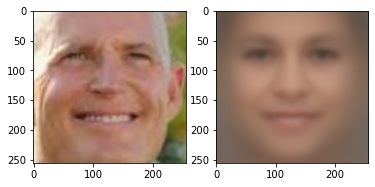

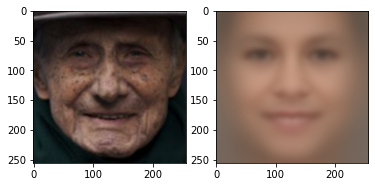

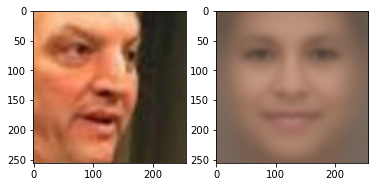

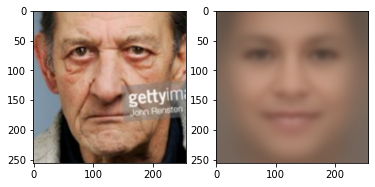

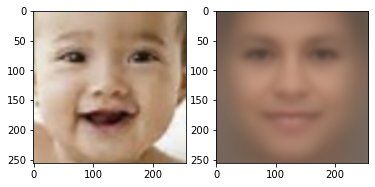

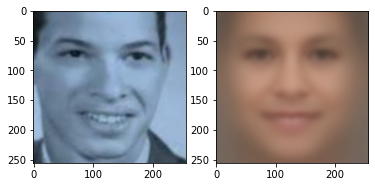

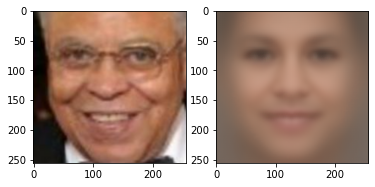

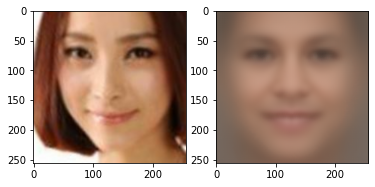

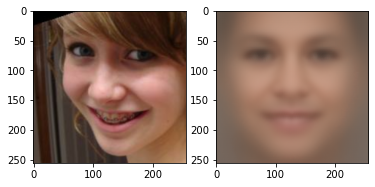

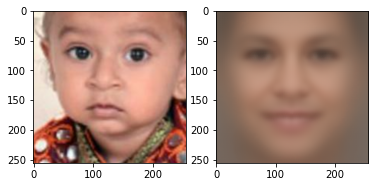

In [17]:
num_images = 10
with h5py.File(train_preds_path, 'r') as f:
    for i in range(num_images):
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(f['images'][i])
        ax[1].imshow(f['preds'][i])

## Evaluate model